### Import relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage.filters as filter
import time
import os
import os.path
import commands
import pickle, gzip
from scipy import interpolate
import optparse as op
from matplotlib import rc
import matplotlib

### Define confidence functions

In [2]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter with 1-sigma softening
def gf(P):
    return filter.gaussian_filter(P, sigma=1.0)

# compute 1-sigma confidence intervals in 1D
def calc_cred_intervals_in_1d(P, x):

    # find the value of P corresponding to 50% and 9% confidence heights
    conf = confidence(P)
    P_s1 = conf.height_from_level(0.5)
    P_s2 = conf.height_from_level(0.9)

    # calculation of condifence edges (values of x corresponding to the height s1 on the two sides)
    x_s1_l = min(x[np.where(P >= P_s1)[0]])
    x_s1_r = max(x[np.where(P >= P_s1)[0]])

    # calculation of condifence edges (values of x corresponding to the height s2 on the two sides)
    x_s2_l = min(x[np.where(P >= P_s2)[0]])
    x_s2_r = max(x[np.where(P >= P_s2)[0]])

    return P_s1, P_s2, x_s1_l, x_s1_r, x_s2_l, x_s2_r

def matched_filter_snr_module(filename):
    data = np.genfromtxt(filename, dtype=None, names=True, usecols=(0,1,2,3,4,5,6))
    var_names = [d[0] for d in data]
    stat_names = data.dtype.names
    matched_filter_snr = data[var_names.index('matched_filter_snr')][stat_names.index('median')+1]
    return matched_filter_snr

### IMRTGR results for individual results

In [3]:
post_loc_root = '/home/abhirup.ghosh/Documents/Work/testGR_IR/runs/systematics_error_characterisation/sxs_injetion_o1o2_noise'
inj_data = np.genfromtxt(post_loc_root + '/SXS_campaign.dat', names=True, dtype=None)
out_dir = post_loc_root + '/imrtgr_results_joint'
os.system('mkdir -p %s/data %s/img'%(out_dir, out_dir))
N_bins = 201

imrtgr_data_list = []

for idx in range(len(inj_data)):
    tag = inj_data[idx]['tag']
    geocentric_end_time = inj_data[idx]['geocentric_end_time']
    if os.path.isfile(post_loc_root + '/%s_%d/imrtgr_results/data/P_dMfbyMf_dchifbychif.dat.gz'%(tag, geocentric_end_time-6)) == True:
        imrtgr_data_list.append(post_loc_root + '/%s_%d/imrtgr_results'%(tag, geocentric_end_time-6))

/home/abhirup.ghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


### Prior for computation of joint posteriors

In [4]:
# load the pickle file containing the interpolant of the prior in delta_Mf/Mf, delta_af/a
prior_file = post_loc_root + '/prior_bbh_average_fits_precessing_alignedspinzprior_compmassmin_10_compmassmax_200_nbins_201_dMfbyMf_lim_2_dafbyaf_lim_2'
f = gzip.open(prior_file+".pklz",'rb')
P_dMfbyMf_dchifbychif_pr_interp_obj = pickle.load(f)

### Computing joint posteriors

/home/abhirup.ghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


event 8: snr_i = 15.00; snr_r = 14.64; M = 110.39
Credible level of the GR value (event 8): 24.6% 
90% credible intervals on dMfbyMfmean (event 8): -0.120, 0.440 
90% credible intervals on dchifbychifmean (event 8): -0.380, 0.360 
event 8 used for joint posterior computation
Credible level of the GR value (combined): 33.7% 
90% credible intervals on dMfbyMfmean (combined): -0.300, 0.520 
90% credible intervals on dchifbychifmean (combined): -1.960, 1.820 
event 16: snr_i = 10.97; snr_r = 19.20; M = 149.24


/home/abhirup.ghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in divide


Credible level of the GR value (event 16): 24.6% 
90% credible intervals on dMfbyMfmean (event 16): 0.440, 0.920 
90% credible intervals on dchifbychifmean (event 16): -0.020, 1.700 
event 16 used for joint posterior computation
Credible level of the GR value (combined): 100.0% 
90% credible intervals on dMfbyMfmean (combined): 0.660, 0.960 
90% credible intervals on dchifbychifmean (combined): 1.680, 1.900 
event 18: snr_i = 17.00; snr_r = 13.77; M = 47.49


/home/abhirup.ghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in multiply


Credible level of the GR value (event 18): 24.6% 
90% credible intervals on dMfbyMfmean (event 18): -0.760, -0.480 
90% credible intervals on dchifbychifmean (event 18): -1.480, -0.360 
event 18 used for joint posterior computation
Credible level of the GR value (combined): 100.0% 
90% credible intervals on dMfbyMfmean (combined): 0.720, 0.720 
90% credible intervals on dchifbychifmean (combined): -2.000, 2.000 
event 20: snr_i = 17.77; snr_r = 15.17; M = 135.81
Credible level of the GR value (event 20): 24.6% 
90% credible intervals on dMfbyMfmean (event 20): -0.440, 0.120 
90% credible intervals on dchifbychifmean (event 20): -0.620, 0.200 
event 20 used for joint posterior computation
Credible level of the GR value (combined): 100.0% 
90% credible intervals on dMfbyMfmean (combined): -0.780, -0.660 
90% credible intervals on dchifbychifmean (combined): -1.900, -1.900 
event 22: snr_i = 18.21; snr_r = 13.33; M = 70.26
Credible level of the GR value (event 22): 24.6% 
90% credible int

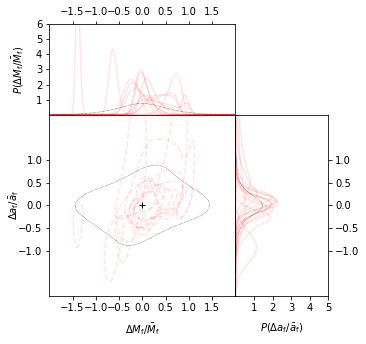

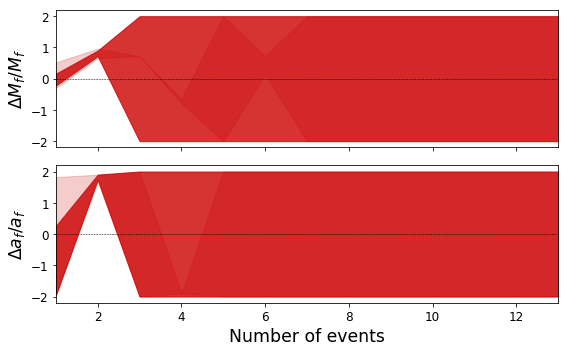

In [14]:
# initialize variables
P_dMfbyMf_dchifbychif_joint = np.ones((N_bins, N_bins))

left1_v1_joint_list = []
left1_v2_joint_list = []
left2_v1_joint_list = []
left2_v2_joint_list = []
right1_v1_joint_list = []
right1_v2_joint_list = []
right2_v1_joint_list = []
right2_v2_joint_list = []

p = plt.figure(figsize=(5,5))
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2)
ax3 = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)

for (idx, post_loc) in enumerate(imrtgr_data_list):

    M = inj_data[idx]['m1'] + inj_data[idx]['m2']
    snr_i = matched_filter_snr_module(post_loc + '/lalinf_insp/summary_statistics.dat')
    snr_r = matched_filter_snr_module(post_loc + '/lalinf_ring/summary_statistics.dat')
    gr_height = np.loadtxt(post_loc + '/data/GR_confidence.txt')
    
    if snr_i > 10 and snr_r > 10 and M < 150:
        print 'event %d: snr_i = %.2f; snr_r = %.2f; M = %.2f'%(idx, snr_i, snr_r, M)

        P_dMfbyMf_dchifbychif = np.loadtxt('%s/data/P_dMfbyMf_dchifbychif.dat.gz'%post_loc)
        dMfbyMf_vec = np.loadtxt('%s/data/dMfbyMf_vec.dat.gz'%post_loc)
        dchifbychif_vec = np.loadtxt('%s/data/dchifbychif_vec.dat.gz'%post_loc)
        P_dMfbyMf_dchifbychif_interp_obj = scipy.interpolate.interp2d(dMfbyMf_vec, dchifbychif_vec, P_dMfbyMf_dchifbychif, fill_value=0., bounds_error=False)	

        # normalize the 2D posterior 
        dx = np.mean(np.diff(dMfbyMf_vec))
        dy = np.mean(np.diff(dchifbychif_vec))
        P_dMfbyMf_dchifbychif /= np.sum(P_dMfbyMf_dchifbychif) * dx * dy

        # compute the credible regions of this posterior
        conf_v1v2 = confidence(P_dMfbyMf_dchifbychif)
        s1_v1v2 = conf_v1v2.height_from_level(0.5)
        s2_v1v2 = conf_v1v2.height_from_level(0.9)

        # compute marginalized 1D posterior 
        P_dMfbyMf = np.sum(P_dMfbyMf_dchifbychif, axis=0) * dy
        P_dchifbychif = np.sum(P_dMfbyMf_dchifbychif, axis=1) * dx
        P_dMfbyMf /= np.sum(P_dMfbyMf) * dx
        P_dchifbychif /= np.sum(P_dchifbychif) * dy

        # calcualte the credible levels and intervals in the marginalized 1d posteriors (this event)
        s1_v1, s2_v1, left1_v1, right1_v1, left2_v1, right2_v1 = calc_cred_intervals_in_1d(P_dMfbyMf, dMfbyMf_vec)
        s1_v2, s2_v2, left1_v2, right1_v2, left2_v2, right2_v2 = calc_cred_intervals_in_1d(P_dchifbychif, dchifbychif_vec)

        print 'Credible level of the GR value (event %d): %.1f%% '%(idx, 100.*gr_credib_level)
        print '90%% credible intervals on dMfbyMfmean (event %d): %2.3f, %2.3f '%(idx, left2_v1, right2_v1)
        print '90%% credible intervals on dchifbychifmean (event %d): %2.3f, %2.3f '%(idx, left2_v2, right2_v2)

        # plot the posteriors of individual events
        ax1.plot(dMfbyMf_vec, P_dMfbyMf, color='r', alpha=0.1)
        ax2.plot(P_dchifbychif, dchifbychif_vec, color='r', alpha=0.1)
        ax3.contour(dMfbyMf_vec,dchifbychif_vec, gf(P_dMfbyMf_dchifbychif), levels=(s2_v1v2,), colors='r', linestyles='dashed', alpha=0.1)

        # evaluate the prior interpolant
        P_dMfbyMf_dchifbychif_pr = P_dMfbyMf_dchifbychif_pr_interp_obj(dMfbyMf_vec, dchifbychif_vec)
        P_dMfbyMf_dchifbychif_pr /= np.sum(P_dMfbyMf_dchifbychif_pr) * dx * dy

        # removing nans
        P_dMfbyMf_dchifbychif[np.isnan(P_dMfbyMf_dchifbychif)] = 0.
        P_dMfbyMf_dchifbychif[np.isinf(P_dMfbyMf_dchifbychif)] = 0.

        # replace all zeros in the posterior vector by a small number.
        # This is to avoid multiplication by zeros while combining the posteiror
        zidx = np.where(P_dMfbyMf_dchifbychif == 0.)
        P_dMfbyMf_dchifbychif[zidx] = 1e-16

        # only use events that cross the IFAR > 1000 threshold for computing combined posteriors 
        if idx == 0:
            print "event %d not used for joint posterior computation"%idx
        elif idx >= 1:
            print "event %d used for joint posterior computation"%idx

            P_dMfbyMf_dchifbychif_joint *= P_dMfbyMf_dchifbychif/P_dMfbyMf_dchifbychif_pr

            # removing nans and inf, normalizing the joint posterior 
            P_dMfbyMf_dchifbychif_joint[np.isnan(P_dMfbyMf_dchifbychif_joint)] = 0.
            P_dMfbyMf_dchifbychif_joint[np.isinf(P_dMfbyMf_dchifbychif_joint)] = 0.
            P_dMfbyMf_dchifbychif_joint /= np.sum(P_dMfbyMf_dchifbychif_joint) * dx * dy

            # compute the credible level of the GR value from the combined posteriors
            conf_v1v2_joint = confidence(P_dMfbyMf_dchifbychif_joint)
            s1_v1v2_joint = conf_v1v2_joint.height_from_level(0.5)
            s2_v1v2_joint = conf_v1v2_joint.height_from_level(0.9)

            # Marginalization to one-dimensional joint_posteriors
            P_dMfbyMf_joint = np.sum(P_dMfbyMf_dchifbychif_joint, axis=0) * dy
            P_dchifbychif_joint = np.sum(P_dMfbyMf_dchifbychif_joint, axis=1) * dx

            # normalisation of individual posteriors
            P_dMfbyMf_joint /= np.sum(P_dMfbyMf_joint) * dx
            P_dchifbychif_joint /= np.sum(P_dchifbychif_joint) * dy

            # calcualte the credible levels and intervals in the marginalized 1d posteriors (joint)
            s1_v1_joint, s2_v1_joint, left1_v1_joint, right1_v1_joint, left2_v1_joint, right2_v1_joint = calc_cred_intervals_in_1d(P_dMfbyMf_joint, dMfbyMf_vec)
            s1_v2_joint, s2_v2_joint, left1_v2_joint, right1_v2_joint, left2_v2_joint, right2_v2_joint = calc_cred_intervals_in_1d(P_dchifbychif_joint, dchifbychif_vec)

            # append the confidence intervals for plotting (joint posteriors) 
            left1_v1_joint_list = np.append(left1_v1_joint_list, left1_v1_joint)
            right1_v1_joint_list = np.append(right1_v1_joint_list, right1_v1_joint)
            left2_v1_joint_list = np.append(left2_v1_joint_list, left2_v1_joint)
            right2_v1_joint_list = np.append(right2_v1_joint_list, right2_v1_joint)
            left1_v2_joint_list = np.append(left1_v2_joint_list, left1_v2_joint)
            right1_v2_joint_list = np.append(right1_v2_joint_list, right1_v2_joint)
            left2_v2_joint_list = np.append(left2_v2_joint_list, left2_v2_joint)
            right2_v2_joint_list = np.append(right2_v2_joint_list, right2_v2_joint)

            # calculate the GR percentile from combined posterior  
            gr_height_joint = P_dMfbyMf_dchifbychif_joint[np.argmin(abs(dMfbyMf_vec)), np.argmin(abs(dchifbychif_vec))]
            gr_credib_level_joint = conf_v1v2_joint.level_from_height(gr_height_joint)
            print 'Credible level of the GR value (combined): %.1f%% '%(100.*gr_credib_level_joint)
            print '90%% credible intervals on dMfbyMfmean (combined): %2.3f, %2.3f '%(left2_v1_joint, right2_v1_joint)
            print '90%% credible intervals on dchifbychifmean (combined): %2.3f, %2.3f '%(left2_v2_joint, right2_v2_joint)
            
################################################## 
# compute final results from combined posteriors # 
##################################################

# Marginalization to one-dimensional prior distributions 
P_dMfbyMf_pr = np.sum(P_dMfbyMf_dchifbychif_pr, axis=0) * dy
P_dchifbychif_pr = np.sum(P_dMfbyMf_dchifbychif_pr, axis=1) * dx

# normalisation of prior distributions 
P_dMfbyMf_pr /= np.sum(P_dMfbyMf_pr) * dx
P_dchifbychif_pr /= np.sum(P_dchifbychif_pr) * dy

# Calculation of credible levels in the 2D prior 
conf_v1v2_pr = confidence(P_dMfbyMf_dchifbychif_pr)
s1_v1v2_pr = conf_v1v2_pr.height_from_level(0.5)
s2_v1v2_pr = conf_v1v2_pr.height_from_level(0.9)

# save the combined posterior data 
np.savetxt(out_dir+'/data/dMfbyMf_vec_joint.dat.gz', dMfbyMf_vec)
np.savetxt(out_dir+'/data/dchifbychif_vec_joint.dat.gz', dchifbychif_vec)
np.savetxt(out_dir+'/data/P_dMfbyMf_dchifbychi_joint.dat.gz', P_dMfbyMf_dchifbychif_joint)
np.savetxt(out_dir+'/data/P_dMfbyMf_joint.dat.gz', P_dMfbyMf_joint)
np.savetxt(out_dir+'/data/P_dchifbychif_joint.dat.gz', P_dchifbychif_joint)

# make plots 
#ax1.fill(dMfbyMf_vec, P_dMfbyMf_joint, 'gray', alpha=0.5)
ax1.plot(dMfbyMf_vec, P_dMfbyMf_pr, 'k',  lw=0.5, ls=':')
#ax2.fill(P_dchifbychif_joint, dchifbychif_vec, 'gray', alpha=0.5)
ax2.plot(P_dchifbychif_pr, dchifbychif_vec, 'k', lw=0.5, ls=':')
#ax3.contourf(dMfbyMf_vec,dchifbychif_vec,gf(P_dMfbyMf_dchifbychif_joint), levels=(s2_v1v2_joint, np.inf), linewidths=(1.5,0.5), colors='gray', linestyles=('--'), alpha=0.5)
ax3.contour(dMfbyMf_vec,dchifbychif_vec,gf(P_dMfbyMf_dchifbychif_pr), levels=(s2_v1v2_pr,), linewidths=(0.5,0.5), colors='k', linestyles=(':'))
ax3.plot(0, 0, 'k+', mew=1)
# axis limits 
ax1.set_xlim(-2,2)
ax1.set_ylim(0,6)
ax2.set_ylim(-2,2)
ax2.set_xlim(0,5)
ax3.set_xlim(-2,2)
ax3.set_ylim(-2,2)
# tick labels 
ax1.xaxis.tick_top()
ax2.yaxis.tick_right()
ax1.set_xticks(np.arange(-1.5, 1.51, 0.5))
ax1.set_yticks(np.arange(1, 7, 1.))
ax2.set_xticks(np.arange(1, 6, 1.))
ax2.set_yticks(np.arange(-1, 1.1, 0.5))
ax3.set_xticks(np.arange(-1.5, 1.51, 0.5))
ax3.set_yticks(np.arange(-1, 1.1, 0.5))
# axis labels and legends 
ax1.legend(bbox_to_anchor=(1.05, 1.1), loc=2, borderaxespad=0.,frameon=False)
ax2.set_xlabel(r'$P(\Delta a_{\mathrm{f}}/ \bar{a}_{\mathrm{f}})$', labelpad=8)
ax1.set_ylabel(r'$P(\Delta M_{\mathrm{f}}/ \bar{M}_{\mathrm{f}})$', labelpad=10)
ax3.set_xlabel(r'$\Delta M_{\mathrm{f}}/ \bar{M}_{\mathrm{f}}$', labelpad=8)
ax3.set_ylabel(r'$\Delta a_{\mathrm{f}}/ \bar{a}_{\mathrm{f}}$', labelpad=-3)
plt.subplots_adjust(wspace=0., hspace=0.)
# save plots 
plt.savefig(out_dir+'/img/dMfbyMf_dchifbychi_joint.pdf', dpi=150)

plt.figure(figsize=(8,5))
ax = plt.subplot(211)
ax.set_xticklabels([])
plt.fill_between(1+np.arange(len(left1_v1_joint_list)), left1_v1_joint_list, right1_v1_joint_list, color='#cc0000', alpha=0.8) #, label='68\%')
plt.fill_between(1+np.arange(len(left2_v1_joint_list)), left2_v1_joint_list, right2_v1_joint_list, color='#cc0000', alpha=0.2) #, label='95\%')
plt.axhline(y=0., color='k', ls='--', lw=0.5)
#plt.ylim(-0.4,0.4)
plt.xlim([1, len(left1_v1_joint_list)])
plt.ylabel('$\Delta M_f/M_f$', fontsize='xx-large')
plt.yticks(fontsize = 'large')
plt.subplot(212)
plt.fill_between(1+np.arange(len(left1_v2_joint_list)), left1_v2_joint_list, right1_v2_joint_list, color='#cc0000', alpha=0.8) #, label='68\%')
plt.fill_between(1+np.arange(len(left2_v2_joint_list)), left2_v2_joint_list, right2_v2_joint_list, color='#cc0000', alpha=0.2) #, label='95\%')
plt.axhline(y=0., color='k', ls='--', lw=0.5)
#plt.ylim(-0.4,0.4)
plt.xlim([1, len(left1_v2_joint_list)])
plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.xlabel('Number of events', fontsize='xx-large')
plt.ylabel('$\Delta a_f/a_f$', fontsize='xx-large')
plt.tight_layout()
plt.savefig(out_dir+'/img/dMfbyMf_dchifbychif_jointposterior_vs_events_GR_injections.pdf', dpi=300)

plt.show()
            